# Two Modes

In [2]:
import torch
import seaborn as sns
from torch import distributions

from torch import nn, optim
import math
from tqdm import tqdm

from pyro import distributions as dist
from pyro.distributions import transforms as T
import matplotlib.pyplot as plt

In [3]:
theta_mu1 = -0.75
theta_mu2 = 0.75
theta_std=0.5
grid = torch.linspace(-5, 5, 1024)

In [4]:
logp = distributions.Normal(torch.tensor([theta_mu1, theta_mu2]), torch.tensor(theta_std)).log_prob(grid[:, None]).logsumexp(-1)

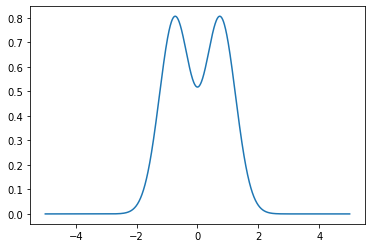

In [5]:
plt.plot(grid, logp.exp())

In [6]:
theta = torch.cat([theta_mu1 + torch.randn(512) * theta_std, theta_mu2 + torch.randn(512) * theta_std])

<AxesSubplot:ylabel='Density'>

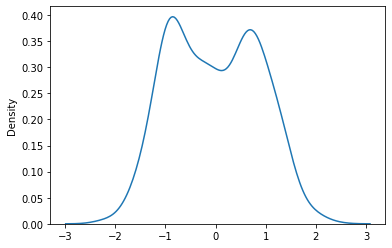

In [7]:
sns.kdeplot(theta)

In [8]:
x = theta.abs() + torch.randn(1024) * 0.1

<AxesSubplot:ylabel='Density'>

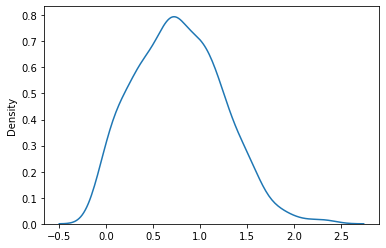

In [9]:
sns.kdeplot(x)

In [10]:
def logprob_x_theta(x, theta):
    return distributions.Uniform(-5, 5).log_prob(theta) + distributions.Normal(theta.abs(), .1).log_prob(x)

In [11]:
@torch.no_grad()
def rejection_sampling(fn, rng, num_samples=1024, batch_size=32768, max_log_prob=0, n_dims=1):
    z = torch.Tensor()
    i = 0
    while len(z) < num_samples:
        eps = torch.rand((num_samples, n_dims))
        min, max = rng
        z_ = eps * (max - min) + min
        prob = torch.rand(num_samples)

        logprob = fn(z_).squeeze()
        prob_ = torch.exp(logprob - max_log_prob)
        accept = prob_ > prob
        z = torch.cat([z, z_[accept, :]])
        i += 1
    return z[:num_samples]

In [12]:
x0 = x[0]

In [13]:
p_theta_x0 = rejection_sampling(lambda theta: logprob_x_theta(x0, theta), (-5, 5), max_log_prob=1.2, num_samples=128)

<AxesSubplot:ylabel='Density'>

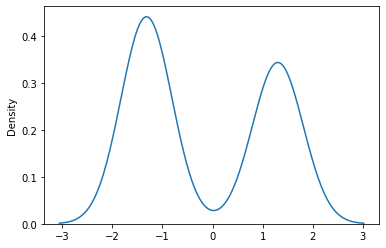

In [14]:
sns.kdeplot(p_theta_x0.squeeze())

In [15]:
theta_samples = []
for x0 in tqdm(x):
#     print(x0)
    p_theta_x0 = rejection_sampling(lambda theta: logprob_x_theta(x0, theta), (-5, 5), max_log_prob=1.2, num_samples=128)
    theta_samples.append(p_theta_x0)

100%|███████████████████████████████████████| 1024/1024 [01:08<00:00, 14.90it/s]


In [16]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transform = [T.planar(1) for _ in range(4)]
composed_transform = T.ComposeTransformModule(transform)

transformed_dist = dist.TransformedDistribution(base_dist, composed_transform.inv)
optimizer = torch.optim.Adam(composed_transform.parameters(), lr=1e-2)


In [82]:
steps = 1024

for step in range(steps):
    optimizer.zero_grad()
    loss = -transformed_dist.log_prob(theta[:, None]).mean()
    loss.backward()
    optimizer.step()
    
    for t in transformed_dist.transforms:
        t.clear_cache()
        
    if step % 32 == 0:
        print(loss.item())
        


1.9020929336547852
1.3593579530715942
1.3218357563018799
1.3105297088623047
1.2954256534576416
1.2802438735961914
1.2670143842697144
1.2553246021270752
1.2450928688049316
1.2366825342178345
1.2303802967071533
1.2262294292449951
1.2238872051239014
1.222733736038208
1.222196102142334
1.2219319343566895
1.2217885255813599
1.2217049598693848
1.2216547727584839
1.2216235399246216
1.2216033935546875
1.2215888500213623
1.221577525138855
1.2215678691864014
1.2215588092803955
1.221550464630127
1.221542239189148
1.2215344905853271
1.2215267419815063
1.2215193510055542
1.221511960029602
1.221504807472229


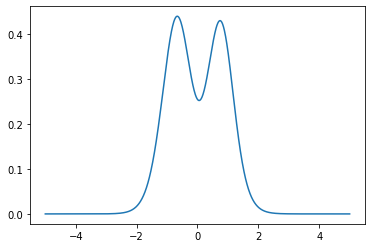

In [18]:
with torch.no_grad():
    plt.plot(grid, transformed_dist.log_prob(grid[:, None]).exp())

In [23]:
theta_samples = torch.stack(theta_samples)

In [24]:
theta_samples.shape

torch.Size([1024, 128, 1])

In [61]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transform = [T.planar(1) for _ in range(4
                                       )]
composed_transform = T.ComposeTransformModule(transform)

transformed_dist = dist.TransformedDistribution(base_dist, composed_transform.inv)


In [62]:
optimizer = torch.optim.Adam(composed_transform.parameters(), lr=1e-2)


<AxesSubplot:ylabel='Density'>

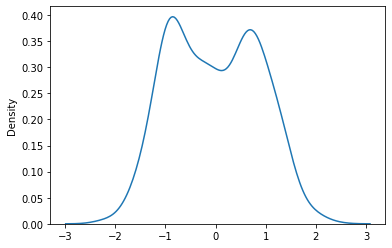

In [63]:
sns.kdeplot(theta.squeeze())

0 1.9425272941589355


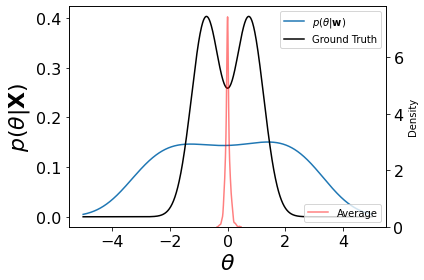

128 1.3093807697296143


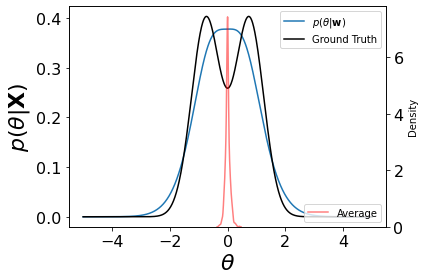

256 1.279417872428894


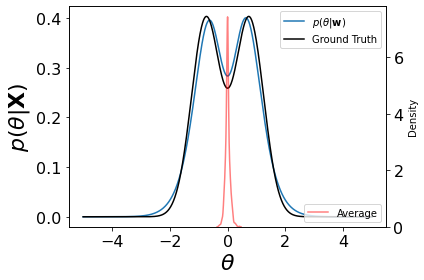

384 1.2787669897079468


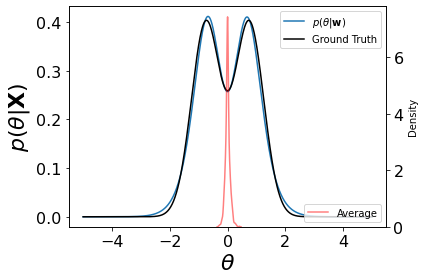

512 1.274661660194397


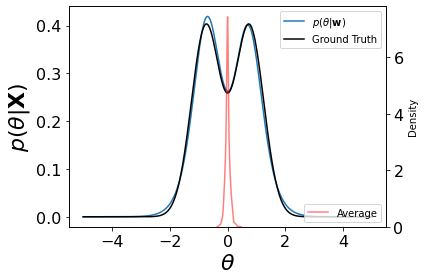

640 1.2709928750991821


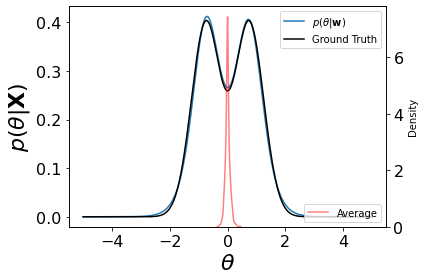

768 1.270383358001709


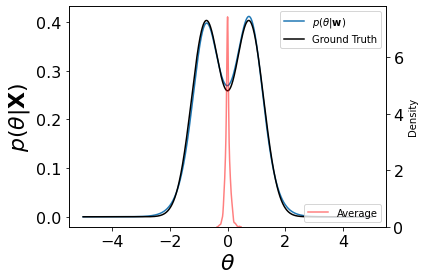

KeyboardInterrupt: 

In [64]:
steps = 131072

for step in range(steps):
    optimizer.zero_grad()
    theta_batch = theta_samples[:, torch.randint(0, 128, (1,))]
    logprob = transformed_dist.log_prob(theta_batch.view(-1, 1)).view(theta_batch.shape)
    
    # Uniform prior so don't need to divide.
    logprob = torch.logsumexp(logprob, dim=1)
    logprob = logprob.mean()
    loss = -logprob
    loss.backward()
    optimizer.step()
    
    for t in transformed_dist.transforms:
        t.clear_cache()
        
    if step % 128 == 0:
        print(step, loss.item())

        with torch.no_grad():
#             plt.figure(facecolor='white')
            fig, ax1 = plt.subplots(facecolor='white')
            ax2 = ax1.twinx()
#             ax1.plot(x, y1, 'g-')
#             ax2.plot(x, y2, 'b-')

            ax1.plot(grid, transformed_dist.log_prob(grid[:, None]).exp(), label=r'$p(\theta | \mathbf{w})$')
            ax1.plot(grid, logp.exp() / 2, label='Ground Truth', color='black')
            sns.kdeplot(theta_samples.mean(1).squeeze(), ax=ax2, color='red', label='Average', alpha=0.5)
            ax1.set_ylabel(r'$p(\theta|\mathbf{X})$', fontsize=22)
#             plt.ylabel(r'$p(\theta|\mathbf{X})$', fontsize=22)
            ax1.set_xlabel(r'$\theta$', fontsize=22)

#             ax1.yticks(fontsize=16)
            ax1.tick_params(labelsize=16)
            ax2.tick_params(labelsize=16)
            plt.xticks(fontsize=16)
            ax1.legend()
            
            ax2.legend(loc='lower right')

            plt.tight_layout()
            plt.savefig(f"toy_result_{step}.pdf")
            plt.show()


In [ ]:
sns.kdeplot(theta_samples.mean(1).squeeze())

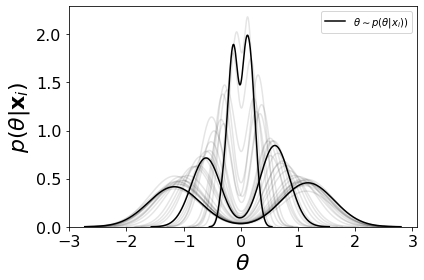

In [264]:
plt.figure(facecolor='white')

for i in range(32):
    alpha = 1 if i in (0, 5, 4) else 0.1
    label =r'$\theta \sim p(\theta|x_i)$)' if i ==0 else None
    sns.kdeplot(theta_samples[i, :, 0], c='black', alpha=alpha, label=label)
plt.legend()
plt.ylabel(r'$p(\theta|\mathbf{x}_i)$', fontsize=22)
plt.xlabel(r'$\theta$', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.tight_layout()
plt.savefig('p_theta_x.pdf', bbox_inches='tight')
# plt.title(r"Posteriors $p(\theta|\mathbf{x}_i)$ for $i \in \{1, \dots, N\}$")